# Animal Shelter Outcomes
![](Image/title.png)

# DESCRIPTION AND SCOPE
The details of this project come from a Kaggle practice named **SHELTER ANIMAL OUTCOMES**. The dataset contains the details about each individual animal in shelter. The main aim is to predict the outcome of animal which has 5 possible values; adopted, died, euthanasia, returned to owner or transferred to other shelter. Basically, it is a multiple class classification problem. The challenge of this problem is that we need a heavy feature engineering to deal with a bleed attribute which is a categorical feature of OVER 1000 unique values. Also, color attribute is a mix of color and fur pattern which may require some research on this particular subject in order to make a proper data transformation. We plan to use neutral network for this classification. Along with stimulation, we believe that we can create more informative attributes.


# WHERE THE DATASETS COME FROM?
The datasets come from **AUSTIN ANIMAL CENTER** from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake.

# HOW LARGE THE DATASETS ARE?
In the test dataset, there are 11456 rows of data meanwhile in train dataset it has 26729 rows.

# ATTRIBUTES EXPLANATION AND DATA PREPROCESSING
## SexUponOutcomes
![](Image/SexUponOutcomes.png)
Let's look at the **SexUponOutcomes** attribute first. There are five types of values which we can reduce it. So the first thing we need to do is to break the column into two by using **whitespace( )** to get a new column with the values only **_male/female_**
![](Image/Sex.png) 

Another splitted column contains **Neutered/Spayed/Intact** values. We notice that **Neutered** and **Spayed** are synonymns to indicate that a pet is not intact. We decide to change them into **Intactness** column which contains only **True/False**
![](Image/Intactness.png)

## Breed
![](Image/Breed.png)
Let's look at the sample value of the breed. There is a slash!! It might be great to separate it out. So we split it into **"Breed1"** and **"Breed2"**. After that we derive a new column **BreedMix** to indicate if it is a mix or not by detecting the word **"Mix"** or detecting if there are values in both **Breed1** and **Breed2** column. The values of **BreedMix** are **1/0**. We also fill the missing values in both **Breed1** and **Breed2** to **"None"**.
![](Image/BreedMix.png)

We also detect hair in both **Breed1** and **Breed2**. If we find there are two types of hair in one pet, we only keep the longer type of hair and extract into a new column called **Hair**
![](Image/Hair2.png)

## Color
![](Image/Color.png)
The picture above is an example values from **Color** attribute. Separate by using **slash(/)** into **PrimaryColor** and **SecondaryColor**. Detect patterns keyword such as Tabby, point, Merle, then derive found patterns into a new column **Patterns**. If two patterns are detected, we concatenated together separeated by **whitespace()** as shown below.
![](Image/colorDone.png)

## Name
![](Image/Name.png)
There are more than thousand distict names. First, we fill all missing names with **"Unknown"**. Then we derive a new column called **NameRank** to rank the first 20 popular name by assigning values from 1-20. The other names that are not in top 20 and unknown names are assigned with value of 500.

## OutcomeType and OutcomeSubtype
![](Image/OutcomeTypeSubType.png)
These two attributes are what we want to predict. There are five possible classes for **OutcomeType** and sixteen possible class for OutcomeSubtype.

In [2]:
%matplotlib inline

# Wonderful Deep learning

In [3]:
import pandas as pd
import numpy as np
import os 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Input
from keras.optimizers import RMSprop, Adam, Adagrad

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, CSVLogger

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

import pydot
pydot.find_graphviz = lambda: True

Using TensorFlow backend.


In [4]:
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
csv_logger = CSVLogger('training.log',append=True)

> on windows

    tensorboard --logdir=C:\Users\heim\Dropbox\DataShop\AustinAnimalShelter\deepLearning\logs

> on linux

    tensorboard --logdir $(pwd)
open this [link](http://192.168.1.100:6006)

# Data preparation

In [5]:
maindf = pd.read_csv('datasets/hand_clean.csv', encoding='latin-1')

/home/heim/anaconda3/envs/3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (0,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Create one more features

In [6]:
maindf['HasName'] = maindf['Name'].apply(lambda x: True if x !='Unknown' else False)
maindf[['HasName','Name']].sample(10)

,HasName,Name
29001,True,Bella
6571,True,Curtis
10366,True,George
25743,False,Unknown
21183,True,Wilbur
33935,True,Bea
27337,False,Unknown
27179,False,Unknown
9437,True,Pete
25230,False,Unknown


## The rest

In [7]:
COLUMNS = ['AnimalID', 'AnimalType', 'Breed1', 'Hair', 'Breed2', 'BreedMix',
       'PrimaryColor', 'SecondaryColor', 'Patterns', 'Intactness', 'Name',
       'NameRank', 'OutcomeSubtype', 'OutcomeType', 'Sex', 'AgeuponOutcomeDay',
       'AgeType', 'Month', 'DayInWeek', 'PartsOfDay', 'HasName']
CATEGORICAL_COLUMNS = ['AnimalType','BreedMix','Breed1','Hair', 'PrimaryColor','Patterns', 'Intactness', 'HasName', 
                       'PartsOfDay', 'DayInWeek', 'Month','AgeType', 'Sex']
CONTINUOUS_COLUMNS = ['AgeuponOutcomeDay']
TEXTUAL_COLUMNS = ['Name','Breed1','Breed2','PrimaryColor','SecondaryColor', 'Patterns']

TARGET_COLUMNS = [ 'OutcomeSubtype', 'OutcomeType']
META_COLUMNS = ['AnimalID', 'NameRank','Breed2','SecondaryColor','Name']

simple_X = maindf.drop(META_COLUMNS + TARGET_COLUMNS, axis=1)
simple_X = pd.get_dummies(simple_X,columns=CATEGORICAL_COLUMNS)

simple_Y = maindf[TARGET_COLUMNS]
simple_Y = pd.get_dummies(simple_Y)

simple_meta = maindf[META_COLUMNS]

fulltrain_X = simple_X[maindf.OutcomeType.notnull()]
fulltrain_Y = simple_Y[maindf.OutcomeType.notnull()]

sample_X = fulltrain_X.sample(1000)
sample_Y = fulltrain_Y.loc[sample_X.index,:]

train_X,valid_X,train_Y,valid_Y = train_test_split(fulltrain_X,fulltrain_Y,test_size=0.1,random_state=32)

test_X = simple_X[maindf.OutcomeType.isnull()]
test_Y = simple_Y[maindf.OutcomeType.isnull()]
test_meta = simple_meta[maindf.OutcomeType.isnull()]

INPUT_DIM = 314

# Data of others

In [ ]:
def getElseDf():
    train_ori = pd.read_csv('datasets/rf_train.csv')
    test_ori = pd.read_csv('datasets/rf_test.csv')

    train = train_ori[['AnimalType','AgeinDays','HasName','Hour', 'Weekday',
           'Month', 'TimeofDay', 'IsMix', 'SimpleBreed', 'SimpleColor',
           'Intact', 'Sex', 'Lifestage', 
            'OutcomeType', 'OutcomeSubtype']]
    test = test_ori[['AnimalType','AgeinDays','HasName','Hour', 'Weekday',
           'Month', 'TimeofDay', 'IsMix', 'SimpleBreed', 'SimpleColor',
           'Intact', 'Sex', 'Lifestage']]

    CATEGORICAL_COLUMNS = ["AnimalType", "TimeofDay", "SimpleBreed", "SimpleColor","Sex", "Lifestage", "HasName", "Weekday", "Month", "IsMix", "Intact"]
    CONTINUOUS_COLUMNS = ["AgeinDays", "Hour" ]

    all_X = pd.concat([train_X,test_X])
    all_X = pd.get_dummies(all_X,columns=CATEGORICAL_COLUMNS)

    train_X = all_X.iloc[:train_X.shape[0],:]
    train_y = pd.get_dummies(train_y)
    test_X = all_X.iloc[train_X.shape[0]:,:]
    train_y_sub = pd.get_dummies(train_y_sub,dummy_na=True)
    train_y_main = pd.get_dummies(train_y_main)
    train_X_sub = train_X

def getOurDf():
    maindf = pd.read_csv('datasets/hand_clean.csv')
    test_ori = pd.read_csv('datasets/rf_test.csv')

In [ ]:
maindf = pd.read_csv('datasets/hand_clean.csv', encoding='latin-1')

In [ ]:
df={}
df['kaggle'] = {}
df['else'] = {}
df['our'] = {}

# Simple NN
![](Image/neural_network.png)
What is a neural network? A neural network is a “connectionist” computational system. The computational systems we write are procedural; a program starts at the first line of code, executes it, and goes on to the next, following instructions in a linear fashion. A true neural network does not follow a linear path. Rather, information is processed collectively, in parallel throughout a network of nodes (the nodes, in this case, being neurons). - Daniel Shiffman

## define model

In [16]:
model = Sequential()
model.add(Dense(50, input_dim=INPUT_DIM))
#     if dropout > 0: model.add(Dropout(dropout))
#     model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dense(5))
model.add(Activation('softmax'))


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
def gen_model():
    model = Sequential()
    model.add(Dense(200, input_dim=INPUT_DIM))
    #     if dropout > 0: model.add(Dropout(dropout))
    #     model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Dense(5))
    model.add(Activation('softmax'))


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               31500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
_________________________________________________________________


## load weight

In [ ]:
model.load_weights('models/snn_2.h5')

## train model

In [20]:
fitNN('sNN100 dense50 1',lr=.01, ep=100)

In [44]:
hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[csv_logger], epochs=10, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 1s - loss: 0.2895 - acc: 0.8693 - val_loss: 0.3106 - val_acc: 0.8525

In [40]:
hist.

In [45]:
history_of_fitting = []
def fitNetForRMSProp(model,ep = 10,lr = .001):
    model.optimizer = Adam(lr=lr)
    hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[tensorboard,csv_logger], epochs=10, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [47]:
fitNetForRMSProp(model, 10, .0001)

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 1s - loss: 0.2828 - acc: 0.8725 - val_loss: 0.2948 - val_acc: 0.8670

In [54]:
test_meta

,AnimalID,NameRank,Breed2,SecondaryColor,Name
26729,1,500,None,White,Summer
26730,2,500,Siberian Husky,Tan,Cheyenne
26731,3,500,None,None,Gus
26732,4,500,None,None,Pongo
26733,5,500,None,None,Skooter
26734,6,500,None,White,Beau
26735,7,500,None,White,Bobo
26736,8,500,None,None,Abby
26737,9,500,None,Cream,Ruby Grace
26738,10,500,None,White,Ruby


## predict

In [66]:
def npToSubmit(filename):
    global model
    submit = model.predict(test_X.values,verbose=1)
    submit = npArray
    df_submit = pd.DataFrame(npArray,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
    a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
    a.drop(['index'],axis=1,inplace=True)
    a.rename(columns={'AnimalID':'ID'},inplace=True)
    a.to_csv(filename, index=False)
    return a
df_res = npToSubmit(submit, 'submits/kaggle sNN 2.csv')

11040/11456 [===========================>..] - ETA: 0s

In [68]:
df_res

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.083646,0.001063,0.078499,0.232762,0.604029
1,2,0.654748,0.000120,0.009184,0.287964,0.047984
2,3,0.243531,0.002473,0.018800,0.054364,0.680832
3,4,0.429736,0.002071,0.022635,0.328145,0.217413
4,5,0.430379,0.000124,0.018379,0.476451,0.074668
5,6,0.390075,0.000262,0.029091,0.480452,0.100121
6,7,0.084667,0.000771,0.362294,0.285619,0.266649
7,8,0.555221,0.004957,0.005083,0.049361,0.385378
8,9,0.760260,0.000350,0.001520,0.177207,0.060662
9,10,0.506946,0.000097,0.012851,0.444148,0.035958


In [ ]:
train_y.shape

In [69]:
model.save_weights('models/snn_2.h5')

# n-hidden layer nn (universal approximate)

## first try- no dropout, no batchnorm

### define model

In [72]:
model = Sequential()

model.add(Dense(100, input_dim=INPUT_DIM))
model.add(Activation('tanh'))


model.add(Dense(100))
model.add(Activation('tanh'))

model.add(Dense(100))
model.add(Activation('tanh'))

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### training

In [77]:
history_of_fitting = []
def fitNN(model,ep = 10,lr = .001):
    model.optimizer = Adam(lr=lr)
    hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [74]:
fitNN(model,ep=5)

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 1s - loss: 0.3409 - acc: 0.8481 - val_loss: 0.3340 - val_acc: 0.8539

In [75]:
fitNN(model,ep=10)

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 1s - loss: 0.3003 - acc: 0.8654 - val_loss: 0.3032 - val_acc: 0.8630

In [78]:
fitNN(model,ep=32)

Train on 24056 samples, validate on 2673 samples
Epoch 1/32
24056/24056 [==============================] - 1s - loss: 0.2809 - acc: 0.8725 - val_loss: 0.3153 - val_acc: 0.8570

In [1]:
plotLoss()

NameError: name 'history_of_fitting' is not defined

In [86]:
fitNN(model,ep=50)
plotLoss()

Train on 24056 samples, validate on 2673 samples
Epoch 1/50
24056/24056 [==============================] - 1s - loss: 0.2621 - acc: 0.8784 - val_loss: 0.3266 - val_acc: 0.8617

NameError: name 'plotLoss' is not defined

## second try - dropout x batchnorm
> there is overfitting in our model. So, we need some kind of regularization

### define model

In [18]:
dropout_rate = 0.7
model = Sequential()

model.add(Dense(100, input_dim=INPUT_DIM))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate/2))


model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
dropout_rate = 0.7
model = Sequential()

model.add(Dense(200, input_dim=INPUT_DIM))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate/2))


model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
fitNN('HNN do 0.7 fine 2', ep=10,lr=0.001)

### train

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 3s - loss: 0.4227 - acc: 0.8060 - val_loss: 0.3641 - val_acc: 0.8376

<IPython.core.display.Javascript object>


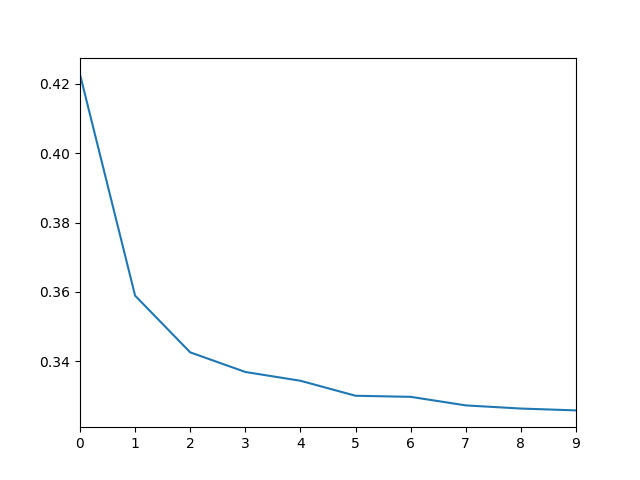

In [18]:
fitNN(model,ep=10)
plotLoss()

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 3s - loss: 0.3251 - acc: 0.8546 - val_loss: 0.3124 - val_acc: 0.8624

<IPython.core.display.Javascript object>


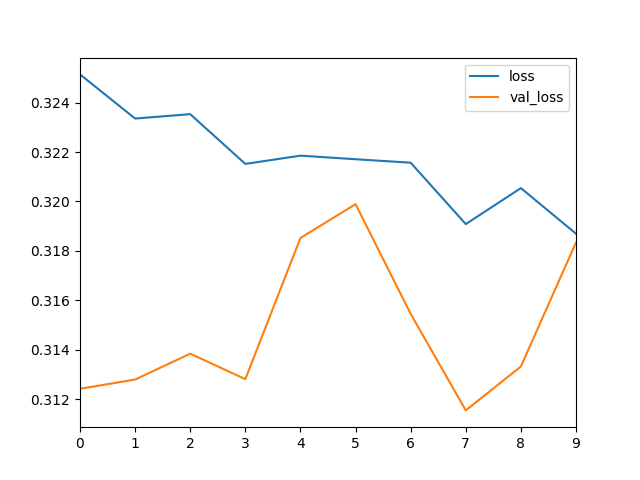

In [22]:
fitNN(model,ep=10)
plotLoss()

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 3s - loss: 0.3193 - acc: 0.8573 - val_loss: 0.3118 - val_acc: 0.8594

<IPython.core.display.Javascript object>


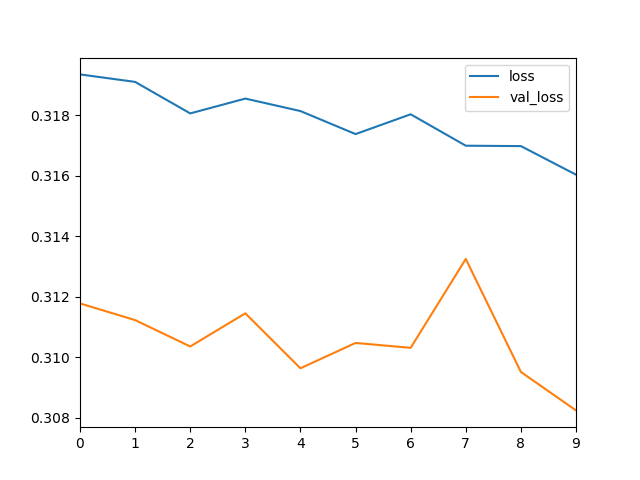

In [23]:
fitNN(model,ep=10,lr=.0001)
plotLoss()

Train on 24056 samples, validate on 2673 samples
Epoch 1/10
24056/24056 [==============================] - 3s - loss: 0.3140 - acc: 0.8599 - val_loss: 0.3074 - val_acc: 0.8637

<IPython.core.display.Javascript object>


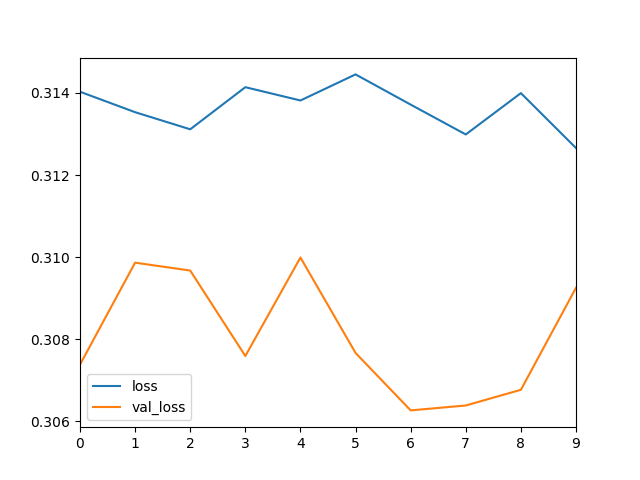

In [25]:
fitNN(model,ep=10,lr=.00001)
plotLoss()

In [26]:
model.save_weights('models/2hnn_1.h5')

### predict

In [26]:
npToSubmit('submits/1hnn_do7.csv')

 9856/11456 [========================>.....] - ETA: 0s

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,2.560925e-01,7.592084e-03,9.727217e-02,2.858355e-01,0.353208
1,2,7.329461e-01,3.746813e-04,3.506536e-03,1.399004e-01,0.123272
2,3,4.461192e-01,5.199254e-03,4.195262e-02,1.868970e-01,0.319832
3,4,6.318972e-01,3.594753e-03,2.278043e-02,9.630689e-02,0.245421
4,5,5.515826e-01,1.310091e-03,2.111862e-02,2.081064e-01,0.217882
5,6,4.707442e-01,2.961147e-03,3.810483e-02,2.695660e-01,0.218624
6,7,2.030873e-01,8.620357e-03,1.174033e-01,2.759409e-01,0.394948
7,8,7.195156e-01,2.931645e-03,1.262929e-02,3.906412e-02,0.225859
8,9,8.664278e-01,4.557200e-05,9.037243e-04,1.078868e-01,0.024736
9,10,5.243213e-01,2.127459e-03,2.498293e-02,2.525911e-01,0.195977


# multitask & transfer learning nn

The concept was introduced in Marc'Aurelio's CVPR 2014 tutorial(https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxsc3ZydHV0b3JpYWxjdnByMTR8Z3g6Njg5MmZkZTM1MDhhZWNmZA), 92page, or as below:
![](https://camo.githubusercontent.com/9b5b091d632c5b923b706016ca15ee56e70c9958/687474703a2f2f322e62702e626c6f6773706f742e636f6d2f2d74736736742d63547857302f56626e31416c51776e72492f414141414141414143546b2f487a5548794e62547478492f73313630302f53637265656e25324253686f74253242323031352d30372d33302532426174253242253235453125323538342532353842253235453125323538352532354139253235453125323538342532353932253235453125323538352532354145253242362e35352e30312e706e67)

## define model

In [99]:
a = Input(shape=(INPUT_DIM,))
b = Dense(100,activation='relu')(a)
# b = Dense(50,activation='relu')(b)
# c = Dense(100,activation='relu')(b)
# base_model = Model(inputs=a, outputs=c)

outcome = Dense(5,activation='softmax', name='main')(b)
model_outcomeOnly = Model(inputs=a, outputs=outcome)

subTypeOutcome = Dense(16,activation='softmax', name='subtype')(b)
model_outcomeWsubType = Model(inputs=a, outputs=[subTypeOutcome,outcome])
model_outcomeWOsubType = Model(inputs=a, outputs=outcome)

model_outcomeWsubType.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
model_outcomeWOsubType.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss=['binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

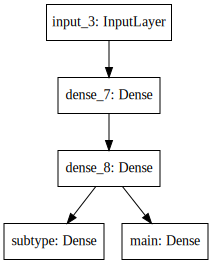

In [98]:
SVG(model_to_dot(model_outcomeWsubType).create(prog='dot', format='svg'))

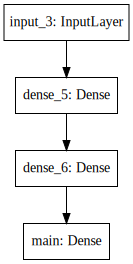

In [33]:
SVG(model_to_dot(model_outcomeOnly).create(prog='dot', format='svg'))

In [35]:
model_outcomeWsubType.layers

In [37]:
model_outcomeWsubType.layers[-2].get_config()

{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'subtype',
 'trainable': True,
 'units': 16,
 'use_bias': True}

In [ ]:
history_of_fitting = []
def fitNNMT(ep = 10,lr = .001):
    global model_outcomeWsubType
    global train_X_wSubType,train_X_woSubType,train_Y_wSubType,train_Y_woSubType,valid_X_wSubType,valid_X_woSubType,valid_Y_wSubType,valid_Y_woSubType
    model_outcomeWsubType.optimizer = Adam(lr=lr)
    
    hist = model_outcomeWsubType.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    
    history_of_fitting.append(hist)

## refine train data

In [37]:
fulltrain_X_wSubType = simple_X[maindf.OutcomeType.notnull() & maindf.OutcomeSubtype.notnull()]
fulltrain_X_woSubType = simple_X[maindf.OutcomeType.notnull() & maindf.OutcomeSubtype.isnull()]

train_Y_wSubType = simple_Y.iloc[fulltrain_X_wSubType.index,:]
train_Y_woSubType = simple_Y.iloc[fulltrain_X_woSubType.index,:]

train_X_wSubType, valid_X_wSubType, train_Y_wSubType, valid_Y_wSubType = train_test_split(fulltrain_X_wSubType, train_Y_wSubType,test_size=0.1,random_state=32)
train_X_woSubType, valid_X_woSubType, train_Y_woSubType, valid_Y_woSubType = train_test_split( fulltrain_X_woSubType,  train_Y_woSubType,test_size=0.1,random_state=32)

## training

In [65]:
def fitMTNN_first(modelGivenName,ep = 10,lr = .001):
    dirA = 'logs/'+modelGivenName
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    tensorboard = TensorBoard(log_dir=dirA, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    global model_outcomeWsubType
    model_outcomeWsubType.optimizer = Adam(lr=lr)
    
    hist = model_outcomeWsubType.fit(train_X_wSubType.values, [train_Y_wSubType.iloc[:,:16].values,train_Y_wSubType.iloc[:,-5:].values],verbose=0, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X_wSubType.values,[valid_Y_wSubType.iloc[:,:16].values,valid_Y_wSubType.iloc[:,-5:].values]))
#     hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [103]:
def fitMTNN(modelGivenName,ep = 10,lr = .001):
    dirA = 'logs/'+modelGivenName+' subtype'
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    tensorboard = TensorBoard(log_dir=dirA, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    global model_outcomeWsubType
    model_outcomeWsubType.optimizer = Adam(lr=lr)
    model_outcomeWsubType.layers[-2].trainable = True
    hist = model_outcomeWsubType.fit(train_X_wSubType.values, [train_Y_wSubType.iloc[:,:16].values,train_Y_wSubType.iloc[:,-5:].values],verbose=0, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X_wSubType.values,[valid_Y_wSubType.iloc[:,:16].values,valid_Y_wSubType.iloc[:,-5:].values]))
    history_of_fitting.append(hist)
    
    dirA = 'logs/'+modelGivenName+' maintypeOnly'
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    tensorboard = TensorBoard(log_dir=dirA, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    model_outcomeWsubType.layers[-2].trainable = False
    hist = model_outcomeWsubType.fit(train_X.values, [train_Y.iloc[:,:16].values,train_Y.iloc[:,-5:].values],verbose=0, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,[valid_Y.iloc[:,:16].values,valid_Y.iloc[:,-5:].values]))
#     hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [86]:

model_outcomeWsubType.layers[-2].trainable = False

In [87]:
model_outcomeWsubType.layers[-2].get_config()

{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'subtype',
 'trainable': False,
 'units': 16,
 'use_bias': True}

In [ ]:
def fitMTNN_second(modelGivenName,ep = 10,lr = .001):
    dirA = 'logs/'+modelGivenName
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    tensorboard = TensorBoard(log_dir=dirA, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    
    #transfer
    model_outcomeWsubType.weights
    
    global model_outcomeWOsubType
    model.optimizer = Adam(lr=lr)
    hist = model_outcomeWOsubType.fit(train_X.values, [train_Y.iloc[:,-5:].values,verbose=0, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
#     hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [66]:
fitMTNN_first('MTNN First', ep=10, lr=0.01)

In [104]:
fitMTNN('MTNN wide Entire 4', ep=10, lr=0.01)

In [91]:
submit = model_outcomeWsubType.predict(test_X.values)

In [78]:
submit[1]

array([  8.00164565e-02,   7.55092036e-03,   1.54361859e-01,
         3.35573277e-04,   7.57735252e-01], dtype=float32)

In [79]:
def npToSubmitMTNN(submit,filename):
    npArray = submit
    df_submit = pd.DataFrame(npArray,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
    a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
    a.drop(['index'],axis=1,inplace=True)
    a.rename(columns={'AnimalID':'ID'},inplace=True)
    a.to_csv(filename, index=False)
    return a

In [ ]:
aa = df_res.iloc[:,1:]

In [92]:
npToSubmitMTNN(submit[1],'MTNN Entire.csv')

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,3.559251e-01,3.533738e-03,6.421994e-02,3.061784e-01,0.270143
1,2,8.012602e-01,1.217849e-03,9.023969e-03,6.183612e-02,0.126662
2,3,7.289246e-01,1.795896e-03,1.373884e-02,7.529943e-02,0.180241
3,4,6.768618e-01,1.951004e-03,1.963037e-02,1.188642e-01,0.182692
4,5,3.559251e-01,3.533738e-03,6.421994e-02,3.061784e-01,0.270143
5,6,3.559251e-01,3.533738e-03,6.421994e-02,3.061784e-01,0.270143
6,7,3.559251e-01,3.533738e-03,6.421994e-02,3.061784e-01,0.270143
7,8,9.250572e-01,4.476239e-04,1.919085e-03,1.640654e-02,0.056170
8,9,8.856567e-01,6.956144e-04,3.759325e-03,2.926665e-02,0.080622
9,10,6.175601e-01,2.281585e-03,2.584877e-02,1.491854e-01,0.205124


# mt nn with dropout

In [ ]:
a = Input(shape=(299,))
b = Dense(500,activation='relu')(a)
b = Dropout(.5)(b)
#b = BatchNormalization()(b)
b = Dense(200,activation='relu')(b)
b = Dropout(.5)(b)
#b = BatchNormalization()(b)
outcome = Dense(5,activation='softmax', name='main')(a)
subTypeOutcome = Dense(17,activation='softmax', name='subtype')(a)
model = Model(inputs=a, outputs=[outcome, subTypeOutcome])
model.compile(optimizer='adam', loss=['binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

In [ ]:
model.fit(train_X_sub.values, [train_y_main.values,train_y_sub.values], epochs=10, batch_size=32, validation_split=0.1)

# Utilities functions

In [13]:
def plotLoss():
    hist = history_of_fitting[-1]
    pd.DataFrame(hist.history)[['loss','val_loss']].plot.line()

<IPython.core.display.Javascript object>


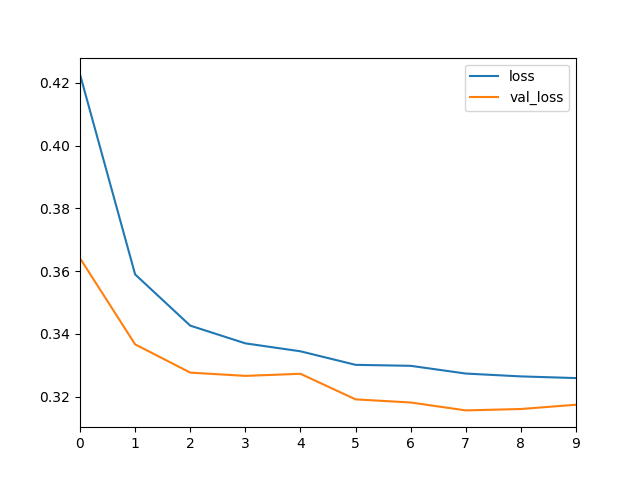

In [21]:
plotLoss()

In [20]:
history_of_fitting = []
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
def fitNN(modelGivenName,ep = 10,lr = .001):
    dirA = 'logs/'+modelGivenName
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    tensorboard = TensorBoard(log_dir=dirA, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    global model
    model.optimizer = Adam(lr=lr)
    hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values,verbose=0, callbacks=[tensorboard,csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
#     hist = model.fit(train_X.values, train_Y.iloc[:,-5:].values, callbacks=[csv_logger], epochs=ep, batch_size=32,validation_data=(valid_X.values,valid_Y.iloc[:,-5:].values))
    history_of_fitting.append(hist)

In [ ]:
def plotLossVal():
    hist = history_of_fitting[-1]
    pd.Series(hist.history['loss']).plot.line()

<IPython.core.display.Javascript object>


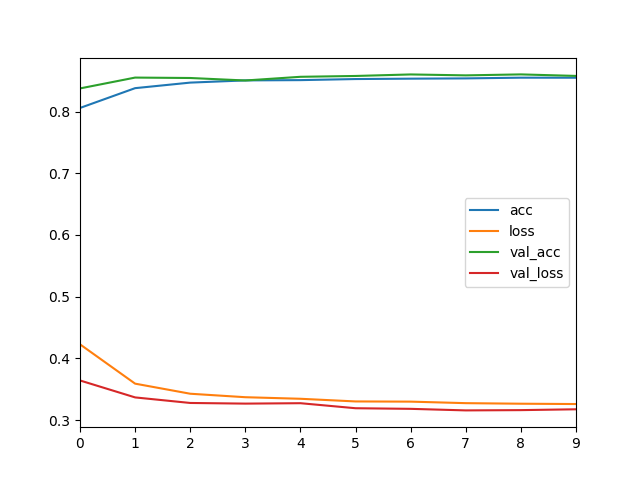

In [19]:
hist = history_of_fitting[-1]
pd.DataFrame(hist.history).plot.line()

In [15]:
def npToSubmit(filename):
    global model
    submit = model.predict(test_X.values,verbose=1)
    npArray = submit
    df_submit = pd.DataFrame(npArray,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
    a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
    a.drop(['index'],axis=1,inplace=True)
    a.rename(columns={'AnimalID':'ID'},inplace=True)
    a.to_csv(filename, index=False)
    return a

In [16]:
def showModelArch():
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
import pydot
pydot.find_graphviz = lambda: True

In [26]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(train_X,train_Y.iloc[:,-5:])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
_.shape

AttributeError: 'list' object has no attribute 'shape'

In [33]:
model_rf.predict_proba(test_X.iloc[0:1,:])

[array([[ 1.,  0.]]),
 array([[ 1.,  0.]]),
 array([[ 1.,  0.]]),
 array([[ 0.9,  0.1]]),
 array([[ 0.1,  0.9]])]

In [ ]:
model_rf.

In [28]:
df_submit = pd.DataFrame(_,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
a.drop(['index'],axis=1,inplace=True)
a.rename(columns={'AnimalID':'ID'},inplace=True)
a.to_csv('submits/rf.csv', index=False)